In [1]:
# Quantum Walk in 1-Dimeintion 
# <Hadamard Walk>

#------ import
#--- qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.primitives import StatevectorSampler

#--- math & graph
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as display
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.font_manager import FontProperties

In [2]:
#--- Parameters
numBitPosition = 4  # qubit for positions -> 4^2 = 16 position
numBitCoin     = 1  # qubit for states

# Simulator settings
shots = 1200
sampler = StatevectorSampler()

# Number of executions (steps)
num_executions = 120

# Function to create the quantum walk circuit with a given number of steps
def create_quantum_walk_circuit(qwStep):
    qc = QuantumCircuit(numBitPosition + numBitCoin, numBitPosition)
    
    # Initial state (center of the histgram)
    # DEC(7), bin(0111), qiskitBiteOrder(1110)  
    qc.x(1)
    qc.x(2)
    qc.x(3)

    # Coin flip and barrier
    qc.h(numBitPosition)
    qc.s(numBitPosition)
    qc.barrier()
    
    # Quantum walk steps
    for i in range(qwStep):
        # Coin flip
        qc.h(4)
        # Shift <adder>
        qc.x(4)
        qc.cx(4, 3)
        qc.ccx(4, 3, 2)
        qc.mcx([4, 3, 2], 1)
        qc.mcx([4, 3, 2, 1], 0)
        # Shift <subtractor>
        qc.x(4)
        qc.mcx([4, 3, 2, 1], 0)
        qc.mcx([4, 3, 2], 1)
        qc.ccx(4, 3, 2)
        qc.cx(4, 3)
    
    # Measurement
    qc.barrier()
    qc.measure([0, 1, 2, 3], [0, 1, 2, 3])
    return qc

# Function to fill counts with zero counts for missing bitstrings
def fill_counts_with_zeros(counts, numBitPosition):
    def decimal_to_base(n, base):
        return format(n, f'{base}')
    
    bitBase = numBitPosition
    base = f'0{bitBase}b'
    
    for i in range(2 ** numBitPosition):
        binary_number = decimal_to_base(i, base)
        if binary_number not in counts:
            counts[binary_number] = 0
    return counts

# Log of results
results_log = []

for steps in range(num_executions):
    qc = create_quantum_walk_circuit(steps)
    result = sampler.run([qc], shots=shots).result()
    
    # Access result data for PUB 0
    data_pub = result[0].data
    
    # Get counts for the classical register "meas"
    counts = data_pub.c.get_counts()
    
    # Fill counts with zero counts for missing bitstrings
    counts = fill_counts_with_zeros(counts, numBitPosition)
    
    results_log.append(counts)

# Convert log to DataFrame
df = pd.DataFrame(results_log).fillna(0).astype(int)

# Insert col
df.insert(0, 'bin(qiskit)', [f'step:{i}' for i in range(num_executions)])

# insert row(decimal)
header_list = df.columns.tolist()

def is_binary_string(s):
    return all(c in '01' for c in s)

# Convert qiskit byte order to reverse order
def reverse_and_convert(header_list):
    converted_list = []

    for item in header_list:
        if not is_binary_string(item):
            if item == 'bin(qiskit)' :
                item = 'dec'
            converted_list.append(item)
            continue
        reversed_item = item[::-1]
        decimal_value = int(reversed_item, 2)
        converted_list.append(decimal_value)
    return converted_list

converted_list = reverse_and_convert(header_list)

new_df = pd.DataFrame([converted_list], columns=df.columns)
df = pd.concat([new_df, df], ignore_index=True)

# sort dec
sorted_columns = ['bin(qiskit)'] + df.iloc[0, 1:].sort_values().index.tolist()
df = df[sorted_columns]

# Save DataFrame to CSV file
df.to_csv('./images/qwh/quantum-walk-hadamard-frequency.csv', index=False)

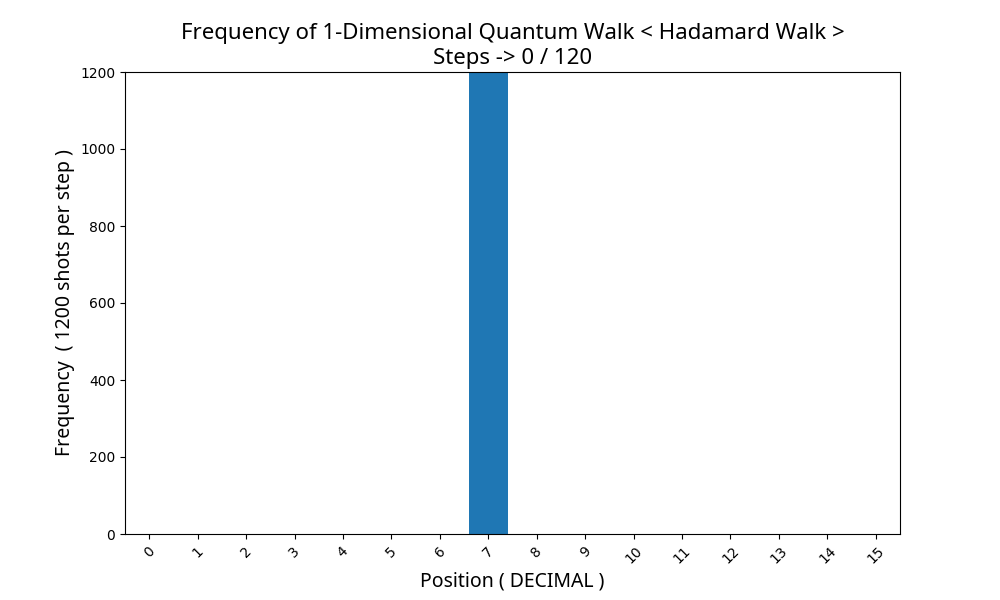

,bin(qiskit),0000,1000,0100,1100,0010,1010,0110,1110,0001,1001,0101,1101,0011,1011,0111,1111
0,dec,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,step:0,0,0,0,0,0,0,0,1200,0,0,0,0,0,0,0,0
2,step:1,0,0,0,0,0,0,619,0,581,0,0,0,0,0,0,0
3,step:2,0,0,0,0,0,293,0,575,0,332,0,0,0,0,0,0
4,step:3,0,0,0,0,161,0,460,0,431,0,148,0,0,0,0,0
5,step:4,0,0,0,78,0,477,0,144,0,420,0,81,0,0,0,0
6,step:5,0,0,42,0,411,0,150,0,144,0,416,0,37,0,0,0
7,step:6,0,21,0,317,0,145,0,154,0,177,0,365,0,21,0,0
8,step:7,5,0,262,0,224,0,126,0,101,0,231,0,246,0,5,0
9,step:8,0,184,0,275,0,123,0,69,0,105,0,272,0,166,0,6


In [3]:
#------ Draw EveryThing
#--- display histgram
def create_histogram_video_from_df(df, output_file, num_executions, shots):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set font properties
    font_path = '/usr/share/fonts/truetype/NotoSans-Regular.ttf'
    font_prop = FontProperties(fname=font_path)

    def update_hist(num):
        ax.clear()
        data = df.iloc[num + 1, 1:]  
        ax.bar(data.index, data.values)
        ax.set_xticks(range(len(data)))
        ax.set_xticklabels(df.iloc[0, 1:].sort_values().values.tolist(), rotation=45)
        ax.set_title(f'Frequency of 1-Dimensional Quantum Walk < Hadamard Walk >\nSteps -> {num} / {num_executions }', fontproperties=font_prop, fontsize=16)
        ax.set_xlabel('Position ( DECIMAL )', fontproperties=font_prop, fontsize=14) 
        ax.set_ylabel(f'Frequency  ( {shots} shots per step )', fontproperties=font_prop, fontsize=14) 
        ax.set_xlim(-0.5, len(data) - 0.5)  
        ax.set_ylim(0, shots)

    ani = FuncAnimation(fig, update_hist, frames=num_executions, repeat=False)
    ani.save(output_file, writer=PillowWriter(fps=2))

create_histogram_video_from_df(df, './images/qwh/quantum-walk-hadamard-histogram.png', num_executions, shots)
plt.close()

output_file_final_image="./images/qwh/quantum-walk-hadamard-histogram.png"
with open(output_file_final_image, 'rb') as f:
    display.display(display.Image(data=f.read(), format='png'))

#--- display dataframe 
# Load the CSV file into a DataFrame
df = pd.read_csv('./images/qwh/quantum-walk-hadamard-frequency.csv')
styled_df = df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
).set_caption('Frequency of 1-Dimensional Quantum Walk < Hadamard Walk >').set_table_styles(
    [{'selector': 'caption', 'props': [('font-size', '24px'), ('text-align', 'center')]}]
).background_gradient(cmap='viridis')
styled_df